In [1]:
# https://www.geodose.com/2018/04/create-gpx-tracking-file-visualizer-python.html

In [2]:
import matplotlib.pyplot as plt
import time
from IPython import display
from xml.dom import minidom
import math
from exif import Image
import base64
import folium
import os
from datetime import datetime


In [3]:
#READ GPX FILE
data=open('Morning_Ride.gpx')
xmldoc = minidom.parse(data)
track = xmldoc.getElementsByTagName('trkpt')
elevation=xmldoc.getElementsByTagName('ele')
date_time=xmldoc.getElementsByTagName('time')
n_track=len(track)

In [4]:
#PARSING GPX ELEMENT
lon_list=[]
lat_list=[]
h_list=[]
time_list=[]
for s in range(n_track):
    lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
    elev=elevation[s].firstChild.nodeValue
    lon_list.append(float(lon))
    lat_list.append(float(lat))
    h_list.append(float(elev))
    # PARSING TIME ELEMENT
    dt=date_time[s].firstChild.nodeValue
    time_split=dt.split('T')
    hms_split=time_split[1].split(':')
    time_hour=int(hms_split[0])
    time_minute=int(hms_split[1])
    time_second=int(hms_split[2].split('Z')[0])
    total_second=time_hour*3600+time_minute*60+time_second
    time_list.append(total_second)

In [5]:
start_finish = [date_time[0].firstChild.nodeValue, date_time[-1].firstChild.nodeValue]
start_finish = [datetime.strptime(start_finish[0], "%Y-%m-%dT%H:%M:%S%z").timestamp(), datetime.strptime(start_finish[1], "%Y-%m-%dT%H:%M:%S%z").timestamp()]

In [6]:
#GEODETIC TO CARTERSIAN FUNCTION
def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y

#DISTANCE FUNCTION
def distance(x1,y1,x2,y2):
    d=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return d

#SPEED FUNCTION
def speed(x0,y0,x1,y1,t0,t1):
    d=math.sqrt((x0-x1)**2+(y0-y1)**2)
    delta_t=t1-t0
    try:
        s=float(d/delta_t)
    except ZeroDivisionError:
        s=0
    return s

In [7]:
#POPULATE DISTANCE AND SPEED LIST
d_list=[0.0]
speed_list=[0.0]
l=0
for k in range(n_track-1):
    if k<(n_track-1):
        l=k+1
    else:
        l=k
    XY0=geo2cart(lon_list[k],lat_list[k],h_list[k])
    XY1=geo2cart(lon_list[l],lat_list[l],h_list[l])
    
    #DISTANCE
    d=distance(XY0[0],XY0[1],XY1[0],XY1[1])
    sum_d=d+d_list[-1]
    d_list.append(sum_d)
    
    #SPEED
    s=speed(XY0[0],XY0[1],XY1[0],XY1[1],time_list[k],time_list[l])
    speed_list.append(s)

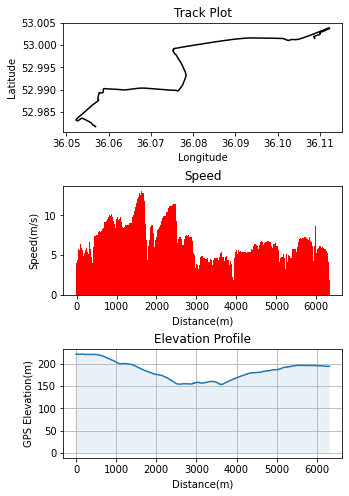

In [8]:
#PLOT TRACK
f,(track,speed,elevation)=plt.subplots(3,1)
f.set_figheight(8)
f.set_figwidth(5)
plt.subplots_adjust(hspace=0.5)
track.plot(lon_list,lat_list,'k')
track.set_ylabel("Latitude")
track.set_xlabel("Longitude")
track.set_title("Track Plot")

#PLOT SPEED
speed.bar(d_list,speed_list,30,color='r')
speed.set_title("Speed")
speed.set_xlabel("Distance(m)")
speed.set_ylabel("Speed(m/s)")

#PLOT ELEVATION PROFILE
base_reg=0
elevation.plot(d_list,h_list)
elevation.fill_between(d_list,h_list,base_reg,alpha=0.1)
elevation.set_title("Elevation Profile")
elevation.set_xlabel("Distance(m)")
elevation.set_ylabel("GPS Elevation(m)")
elevation.grid()

In [10]:
myMap = folium.Map(location=[lat_list[0], lon_list[0]], zoom_start=12)

In [11]:
points = []
for i in range(len(lon_list)):
    points.append([lat_list[i], lon_list[i]])

folium.PolyLine(points, color='red').add_to(myMap)

In [12]:
foldername = "C:\\Users\\TN90072\\Documents\\Python_Scripts\\Problems_VScode"
images = []
for root, dirs, files in os.walk(foldername,topdown = True):
    for name in files: 
        _, ending = os.path.splitext(name)
        if ending == ".jpg":
            images.append(os.path.join(root,name))

In [95]:
images = ["C:\\Users\\TN90072\\Documents\\Python_Scripts\\Problems_VScode\\photowithexif.jpg"]
for image in images:
    with open(image, 'rb') as image_file:
        my_image = Image(image_file)
        
        if my_image.has_exif == False:
            print("File {} has no EXIF".format(image))
            continue

        try:
            lat_deg = int(my_image.gps_latitude[0])
            lat_min = int(my_image.gps_latitude[1])
            lat_sec = my_image.gps_latitude[2]

            lon_deg = int(my_image.gps_longitude[0])
            lon_min = int(my_image.gps_longitude[1])
            lon_sec = my_image.gps_longitude[2]

            lat_sign = my_image.gps_latitude_ref
            lon_sign = my_image.gps_longitude_ref

            decimal_lat = lat_deg + lat_min/60 + lat_sec/3600
            decimal_lon = lon_deg + lon_min/60 + lon_sec/3600
        except AttributeError:
            print("File {} has no coordinates".format(image))
            continue

        if lat_sign == "S":
            decimal_lat *= -1

        if lon_sign == "W":
            decimal_lon *= -1

        photo_time = datetime.strptime(my_image.datetime, "%Y:%m:%d %H:%M:%S").timestamp()
        #if start_finish[1] > photo_time > start_finish[0]:
        #Add Marker
        iframe = '''<iframe width="400" height="225" frameBorder="0" src="{}"</iframe>'''.format('file:///{}'.format(image).replace("\\","/"))
        popup = folium.Popup(iframe, max_width=420)

        folium.Marker(location=[decimal_lat, decimal_lon], tooltip=iframe, popup = popup, 
        icon=folium.Icon(color = 'gray', icon = 'image', prefix='fa')).add_to(myMap) # https://fontawesome.com/icons/image

In [96]:
myMap.save("index.html")

In [97]:
        """
        photo_time = datetime.strptime(my_image.datetime, "%Y:%m:%d %H:%M:%S").timestamp()
        #if start_finish[1] > photo_time > start_finish[0]:
        #Add Marker
        iframe = '''<iframe width="400" height="225" frameBorder="0" src="{}"</iframe>'''.format('file:///{}'.format(image).replace("\\","/"))
        popup = folium.Popup(iframe, max_width=420)

        folium.Marker(location=[decimal_lat, decimal_lon], tooltip=iframe, popup = popup, 
        icon=folium.Icon(color = 'gray', icon = 'image', prefix='fa')).add_to(myMap) # https://fontawesome.com/icons/image
        """

'\nphoto_time = datetime.strptime(my_image.datetime, "%Y:%m:%d %H:%M:%S").timestamp()\n#if start_finish[1] > photo_time > start_finish[0]:\n#Add Marker\niframe = \'\'\'<iframe width="400" height="225" frameBorder="0" src="{}"</iframe>\'\'\'.format(\'file:///{}\'.format(image).replace("\\","/"))\npopup = folium.Popup(iframe, max_width=420)\n\nfolium.Marker(location=[decimal_lat, decimal_lon], tooltip=iframe, popup = popup, \nicon=folium.Icon(color = \'gray\', icon = \'image\', prefix=\'fa\')).add_to(myMap) # https://fontawesome.com/icons/image\n'